In [ ]:
# Data Processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
# Load dataset
file_path = "Coffe_sales.csv"
df = pd.read_csv(file_path)

# Tampilkan 5 data awal
df.head()


,date,datetime,hour_of_day,cash_type,card,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort
0,01/03/2024,01/03/2024 10:15:50,10,card,ANON-0000-0000-0001,R38.70,Latte,Morning,Fri,Mar,5,3
1,01/03/2024,01/03/2024 12:19:22,12,card,ANON-0000-0000-0002,R38.70,Hot Chocolate,Afternoon,Fri,Mar,5,3
2,01/03/2024,01/03/2024 12:20:18,12,card,ANON-0000-0000-0002,R38.70,Hot Chocolate,Afternoon,Fri,Mar,5,3
3,01/03/2024,01/03/2024 13:46:33,13,card,ANON-0000-0000-0003,R28.90,Americano,Afternoon,Fri,Mar,5,3
4,01/03/2024,01/03/2024 13:48:14,13,card,ANON-0000-0000-0004,R38.70,Latte,Afternoon,Fri,Mar,5,3


In [ ]:
# 1. Remove duplicates first
df = df.drop_duplicates()

# 2. Remove the 'R' symbol and convert to float
# This replaces 'R' with nothing, effectively removing it
df["money"] = df["money"].astype(str).str.replace('R', '')

# 3. NOW convert to numeric (it will work now because 'R' is gone)
df["money"] = pd.to_numeric(df["money"])

# 4. Filter missing values or negative numbers
df = df.dropna(subset=["money"])
df = df[df["money"] >= 0]

# Check the results
print("Jumlah baris df :", df.shape)
print(df["money"].describe())


Jumlah baris df : (3636, 12)
count    3636.000000
mean       31.746859
std         4.919926
min        18.120000
25%        27.920000
50%        32.820000
75%        35.760000
max        40.000000
Name: money, dtype: float64


In [ ]:
# Konversi tanggal
df["date"] = pd.to_datetime(df["date"], dayfirst=True)


# Hitung revenue (1 transaksi = 1 baris)
df["revenue"] = df["money"]

# Ekstraksi fitur waktu
df["month"] = df["date"].dt.month
df["day_of_week"] = df["date"].dt.dayofweek  # 0=Senin, 6=Minggu

df.head()


,date,datetime,hour_of_day,cash_type,card,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,revenue,month,day_of_week
0,2024-03-01,01/03/2024 10:15:50,10,card,ANON-0000-0000-0001,38.7,Latte,Morning,Fri,Mar,5,3,38.7,3,4
1,2024-03-01,01/03/2024 12:19:22,12,card,ANON-0000-0000-0002,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,38.7,3,4
2,2024-03-01,01/03/2024 12:20:18,12,card,ANON-0000-0000-0002,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,38.7,3,4
3,2024-03-01,01/03/2024 13:46:33,13,card,ANON-0000-0000-0003,28.9,Americano,Afternoon,Fri,Mar,5,3,28.9,3,4
4,2024-03-01,01/03/2024 13:48:14,13,card,ANON-0000-0000-0004,38.7,Latte,Afternoon,Fri,Mar,5,3,38.7,3,4


In [ ]:
X = df[[
    "coffee_name",
    "hour_of_day",
    "month",
    "day_of_week"
]]

y = df["revenue"]



In [ ]:
# Fitur numerik & kategorikal
numeric_features = [
    "hour_of_day",
    "month",
    "day_of_week"
]

categorical_features = [
    "coffee_name"
]

In [ ]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Pastikan data terurut berdasarkan waktu (Asumsi ada kolom datetime)
# df = df.sort_values('datetime_column')

# 2. Definisi Fitur
numeric_features = ["hour_of_day", "month", "day_of_week"]
categorical_features = ["coffee_name"]

# 3. Setup Preprocessor & Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])

# 4. Implementasi TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

print("Memulai Evaluasi Time Series Cross-Validation...\n")

# Loop untuk melatih dan mengevaluasi model pada setiap 'fold'
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Latih model pada data training fold ini
    pipeline.fit(X_train, y_train)

    # Prediksi pada data test fold ini
    y_pred = pipeline.predict(X_test)

    # Evaluasi
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Fold {i+1}:")
    print(f"  Jumlah Data Train: {len(X_train)}, Test: {len(X_test)}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R2 Score: {r2:.4f}")
    print("-" * 30)

# 5. Opsional: Simpan hasil prediksi terakhir jika diperlukan
# df_hasil = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# df_hasil.to_csv('hasil_prediksi.csv', index=False)

Memulai Evaluasi Time Series Cross-Validation...

Fold 1:
  Jumlah Data Train: 606, Test: 606
  MAE: 2.48
  R2 Score: 0.5451
------------------------------
Fold 2:
  Jumlah Data Train: 1212, Test: 606
  MAE: 0.70
  R2 Score: 0.9204
------------------------------
Fold 3:
  Jumlah Data Train: 1818, Test: 606
  MAE: 0.06
  R2 Score: 0.9935
------------------------------
Fold 4:
  Jumlah Data Train: 2424, Test: 606
  MAE: 1.75
  R2 Score: 0.7221
------------------------------
Fold 5:
  Jumlah Data Train: 3030, Test: 606
  MAE: 1.67
  R2 Score: 0.7628
------------------------------


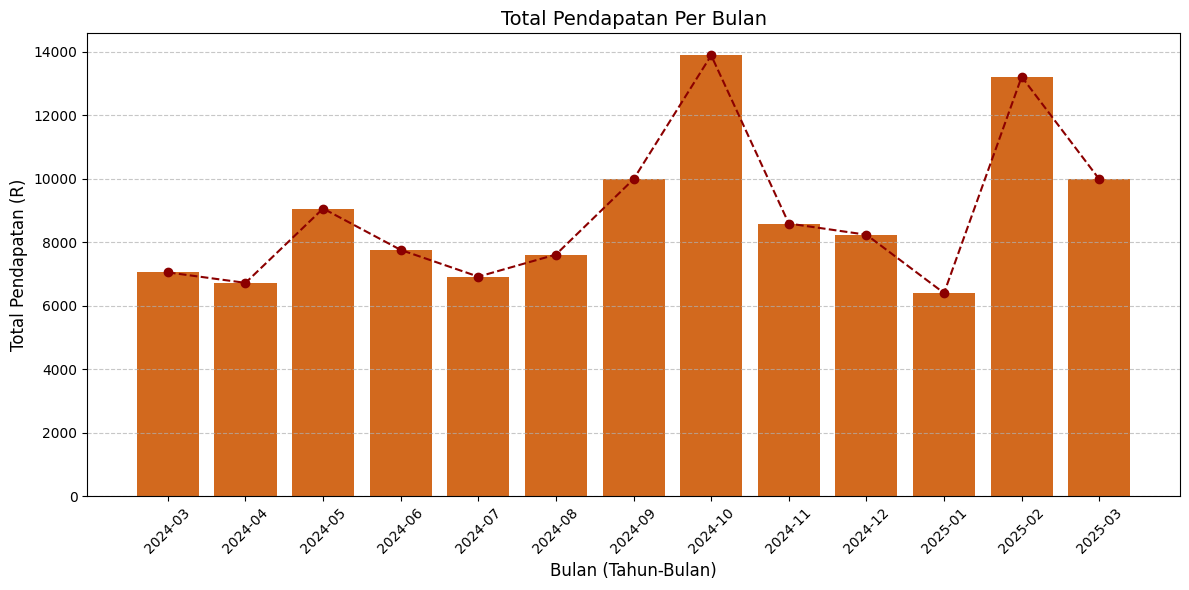

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, date_format
import matplotlib.pyplot as plt

# 1. Inisialisasi Spark Session
spark = SparkSession.builder.appName("CoffeeSalesAnalysis").getOrCreate()

# 2. Load Data
spark_df = spark.read.csv("hasil.csv", header=True, inferSchema=True)

# 3. Pembersihan & Tambah Kolom Bulan
# Kita gunakan date_format agar data urut berdasarkan tahun dan bulan (misal: 2024-01, 2024-02)
spark_df = spark_df.withColumn(
    "revenue_clean",
    regexp_replace(col("money"), "R", "").cast("double")
).withColumn(
    "date",
    col("date").cast("date")
).withColumn(
    "month_year",
    date_format(col("date"), "yyyy-MM")
)

# 4. Agregasi: Hitung total per BULAN
monthly_revenue = spark_df.groupBy("month_year") \
    .sum("revenue_clean") \
    .orderBy("month_year")

# 5. Konversi ke Pandas untuk Visualisasi
pdf_month = monthly_revenue.toPandas()

# 6. Plotting
plt.figure(figsize=(12, 6))
if not pdf_month.empty:
    # Menggunakan bar chart biasanya lebih bagus untuk data bulanan
    plt.bar(pdf_month['month_year'], pdf_month['sum(revenue_clean)'], color='chocolate')

    # Tambahkan garis tren juga jika suka
    plt.plot(pdf_month['month_year'], pdf_month['sum(revenue_clean)'], marker='o', color='darkred', linestyle='--')

    plt.title('Total Pendapatan Per Bulan', fontsize=14)
    plt.xlabel('Bulan (Tahun-Bulan)', fontsize=12)
    plt.ylabel('Total Pendapatan (R)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Data kosong, periksa kembali file hasil.csv Anda.")

In [ ]:
import pandas as pd

# 1. Konversi spark_df ke Pandas (jika belum)
df = spark_df.toPandas()

# 2. Pastikan kolom datetime benar-benar bertipe datetime
df['datetime'] = pd.to_datetime(df['date'])

# 3. Set datetime sebagai index dan urutkan
df_indexed = df.set_index('datetime').sort_index()

# Sekarang Anda bisa memanggil data berdasarkan waktu dengan mudah
# Contoh: Mengambil semua transaksi hanya di bulan Juli
print(df_indexed.loc['2024-07'])

print("Index saat ini:", df_indexed.index.name)
df_indexed.head()



                  date  hour_of_day cash_type                 card  money  \
datetime                                                                    
2024-07-01  2024-07-01           18      card  ANON-0000-0000-0012  23.02   
2024-07-01  2024-07-01           18      card  ANON-0000-0000-0338  37.72   
2024-07-01  2024-07-01           18      card  ANON-0000-0000-0339  37.72   
2024-07-02  2024-07-02           10      card  ANON-0000-0000-0304  32.82   
2024-07-02  2024-07-02           10      card  ANON-0000-0000-0304  27.92   
...                ...          ...       ...                  ...    ...   
2024-07-31  2024-07-31           20      card  ANON-0000-0000-0443  23.02   
2024-07-31  2024-07-31           20      card  ANON-0000-0000-0040  27.92   
2024-07-31  2024-07-31           21      card  ANON-0000-0000-0444  32.82   
2024-07-31  2024-07-31           21      card  ANON-0000-0000-0445  32.82   
2024-07-31  2024-07-31           21      card  ANON-0000-0000-0446  32.82   

,date,hour_of_day,cash_type,card,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,revenue,month,day_of_week,revenue_clean,month_year
datetime,,,,,,,,,,,,,,,,
2024-03-01,2024-03-01,10,card,ANON-0000-0000-0001,38.7,Latte,Morning,Fri,Mar,5,3,38.7,3,4,38.7,2024-03
2024-03-01,2024-03-01,12,card,ANON-0000-0000-0002,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,38.7,3,4,38.7,2024-03
2024-03-01,2024-03-01,12,card,ANON-0000-0000-0002,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,38.7,3,4,38.7,2024-03
2024-03-01,2024-03-01,13,card,ANON-0000-0000-0003,28.9,Americano,Afternoon,Fri,Mar,5,3,28.9,3,4,28.9,2024-03
2024-03-01,2024-03-01,13,card,ANON-0000-0000-0004,38.7,Latte,Afternoon,Fri,Mar,5,3,38.7,3,4,38.7,2024-03
